### Setup

In [1]:
#do not run unless tensorflow can't find cuda
import os
os.environ['CUDA_DIR'] = "/usr/lib/cuda"
os.environ['XLA_FLAGS'] = "--xla_gpu_cuda_data_dir=/usr/lib/cuda"

In [2]:
import tensorflow as tf

2024-04-28 22:37:55.179028: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-28 22:37:55.200969: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-28 22:37:55.200985: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-28 22:37:55.201833: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-28 22:37:55.206049: I tensorflow/core/platform/cpu_feature_guar

In [3]:
tf.__version__

'2.15.0'

In [5]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow.keras import layers
# import tensorflow_probability as tfp

import time

from IPython import display

### Load and prepare the dataset

In [8]:
BUFFER_SIZE = 60000
BATCH_SIZE = 16

In [10]:
import os
import os.path as osp
import cv2
import numpy as np
import pandas as pd

path = '../padded_seg2ct3'
# path = '../cropped_healthy_vertebra'

images = []

for image_file in os.listdir(path):

    img = cv2.imread(osp.join(path, image_file), cv2.IMREAD_GRAYSCALE)
    
    imgflipleft = cv2.flip(img, 1)

    imgflipup = cv2.flip(img, 0)

    imgrot180 = cv2.rotate(img, cv2.ROTATE_180)
    images.append(img)

    images.append(imgflipleft)
    images.append(imgflipup)
    images.append(imgrot180)
        
images = np.array(images)

In [11]:
images.shape

(34552, 128, 128)

In [12]:
images = (images) / 255

In [16]:
train_size = images.shape[0]
images = images.reshape(images.shape[0], 128, 128, 1).astype('float32')


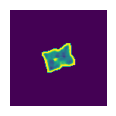

In [18]:
import matplotlib.pyplot as plt

my_dpi = 100
plt.figure(figsize=(1.28, 1.25), dpi=my_dpi)
plt.axis('off')
plt.imshow((images[90,:,:,:]*127.5 + 127.5).astype('int'))
plt.show()

## Load the models

In [19]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(128, 128, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=16*16*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(16, 16, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=128, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

  def generate(self, mean, logvar):
    z = self.reparameterize(mean, logvar)
    x_logit = self.decode(z, apply_sigmoid=True)
    return x_logit

2024-04-28 22:38:25.015427: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-28 22:38:25.043270: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-28 22:38:25.043424: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

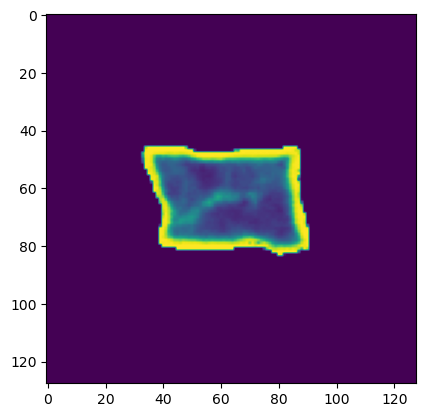

In [20]:
latent_dim = 100
generator = CVAE(latent_dim)
generator.load_weights('./synthetic_cts_variational_autoencoder_generator')

noise_mean = tf.random.normal([1, latent_dim])
noise_logvar = tf.random.normal([1, latent_dim])

generated_image = generator.generate(noise_mean, noise_logvar)

plt.imshow(generated_image[0, :, :, 0])

In [21]:
VAE  = CVAE(latent_dim)
VAE.load_weights('./synthetic_cts_var_ae')

# Generation and Reconstruction Error Calculations 

In [22]:
from tqdm import tqdm
reconstructions_errors = []

for image in tqdm(images):
    mean, logvar = VAE.encode(np.reshape(image, (1, 128,128,1)))
    z = VAE.reparameterize(mean, logvar)
    predictions = VAE.sample(z)

    error = np.array(((image - predictions[0])**2)).mean()
    reconstructions_errors.append(error)

100%|██████████| 34552/34552 [00:59<00:00, 580.82it/s]


In [25]:
from tqdm import tqdm
reconstructions_errors_random = []

for i in tqdm(range(34552)):

    
    random_image = np.random.rand(1,128,128,1)

    mean, logvar = VAE.encode(np.reshape(random_image, (1, 128,128,1)))
    z = VAE.reparameterize(mean, logvar)
    predictions = VAE.sample(z)

    error = np.array(((random_image - predictions[0])**2)).mean()
    reconstructions_errors_random.append(error)

100%|██████████| 34552/34552 [01:04<00:00, 532.60it/s]


In [26]:
from tqdm import tqdm
reconstructions_errors_white = []

for i in tqdm(range(34552)):

    
    white_image = np.ones((1,128,128,1))

    mean, logvar = VAE.encode(np.reshape(white_image, (1, 128,128,1)))
    z = VAE.reparameterize(mean, logvar)
    predictions = VAE.sample(z)

    error = np.array(((white_image - predictions[0])**2)).mean()
    reconstructions_errors_white.append(error)

100%|██████████| 34552/34552 [01:03<00:00, 548.23it/s]


In [27]:
from tqdm import tqdm
reconstructions_errors_generated = []

for i in tqdm(range(34000)):
    noise_mean = tf.random.normal([1, latent_dim])
    noise_logvar = tf.random.normal([1, latent_dim])
    
    generated_image = generator.generate(noise_mean, noise_logvar)
    mean, logvar = VAE.encode(np.reshape(generated_image, (1, 128,128,1)))
    z = VAE.reparameterize(mean, logvar)
    predictions = VAE.sample(z)

    error = np.array(((generated_image - predictions[0])**2)).mean()
    reconstructions_errors_generated.append(error)

100%|██████████| 34000/34000 [02:28<00:00, 229.33it/s]


In [28]:
from tqdm import tqdm
reconstructions_errors_black_with_random = []

for i in tqdm(range(34552)):

    image = np.zeros((128,128))
    image[128//2-25:128//2+25,128//2-25:128//2+25] = np.random.rand(50,50)

    mean, logvar = VAE.encode(np.reshape(image, (1, 128,128,1)))
    z = VAE.reparameterize(mean, logvar)
    predictions = VAE.sample(z)

    error = np.array(((image - predictions[0])**2)).mean()
    reconstructions_errors_black_with_random.append(error)

100%|██████████| 34552/34552 [01:44<00:00, 329.62it/s]


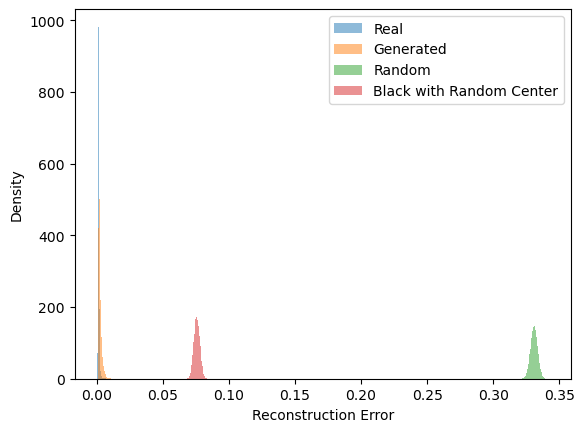

In [33]:
plt.hist(reconstructions_errors,  
         alpha=0.5, # the transaparency parameter 
         label='Real', bins=100, density=True)
plt.hist(reconstructions_errors_generated,  
         alpha=0.5, # the transaparency parameter 
         label='Generated', bins=100, density=True)
plt.hist(reconstructions_errors_random,  
         alpha=0.5, # the transaparency parameter 
         label='Random', bins=100, density=True)
plt.hist(reconstructions_errors_black_with_random,  
         alpha=0.5, # the transaparency parameter 
         label='Black with Random Center', bins=100, density=True)
plt.xlabel("Reconstruction Error")
plt.ylabel("Density")
plt.legend()
plt.show()

In [30]:
average_error_real = sum(reconstructions_errors)/len(reconstructions_errors)

In [31]:
average_error_gen = sum(reconstructions_errors_generated)/len(reconstructions_errors_generated)

In [32]:
abs(average_error_real - average_error_gen)/average_error_real

0.7420599807288629